# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Part V: Multi Assets Algorithmic Trading Backtesting

## 1. Downloading the data:

In [1]:
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Date range
start = '2010-01-01'
end = '2020-10-31'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'NBL', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'AAPL', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'DHR',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'SPY']
assets.sort()

# Downloading data
prices = yf.download(assets, start=start, end=end)
prices = prices.dropna()

[*********************100%***********************]  26 of 26 completed


In [2]:
############################################################
# Showing data
############################################################

display(prices.head())

Adj Close                                                       \
                AAPL        APA        BAX        BMY     CMCSA       CNP   
Date                                                                        
2010-01-04  6.593426  89.088692  25.734049  18.062807  6.925740  9.124897   
2010-01-05  6.604825  90.140579  25.557457  17.780903  6.831876  9.055768   
2010-01-06  6.499768  91.554268  25.645756  17.773859  6.782901  8.967788   
2010-01-07  6.487752  90.165810  26.060741  17.787954  6.925740  9.055768   
2010-01-08  6.530883  89.694572  26.122549  17.491962  6.905335  8.948935   

                                                        ...     Volume  \
                  CPB         DE        DHR        HPQ  ...        NBL   
Date                                                    ...              
2010-01-04  24.188265  44.185638  18.500912  17.847008  ...  2227600.0   
2010-01-05  24.231112  44.020134  18.478752  17.921865  ...  3523000.0   
2010-01-06  23.959742  43.901901  18.513220  17.755129  ...  2030200.0   
2010-01-07  23.595522  44.217175  18.665852  17.761944  ...  2110000.0   
2010-01-08  23.445551  45.423100  18.926809  17.894646  ...  2303000.0   

                                                                      \
                    NI       PCAR        PSA        SEE          SPY   
Date                                                                   
2010-01-04   6905600.0  2631700.0  1579100.0   920400.0  118944600.0   
2010-01-05   8784300.0  2299300.0  1131000.0   831400.0  111579900.0   
2010-01-06   7382700.0  3565000.0   832400.0  1334400.0  116074400.0   
2010-01-07   7407200.0  2455700.0  1284100.0  1394900.0  131091100.0   
2010-01-08  15739200.0  2404300.0  1281100.0   702900.0  126402800.0   

                                                            
                   TGT         TXT          VZ        ZION  
Date                                                        
2010-01-04   4589100.0   3630600.0  16176600.0   3974600.0  
2010-01-05   4760100.0  12121100.0  23722900.0   5605500.0  
2010-01-06   7217400.0   5598300.0  37506400.0  12615200.0  
2010-01-07  12531000.0   5196100.0  25508200.0  24716800.0  
2010-01-08   6512800.0   4104000.0  20658300.0   6903000.0  

[5 rows x 156 columns]

## 2. Building the Backtest Function with Backtrader

### 2.1 Defining Backtest Function

In [3]:
############################################################
# Defining the backtest function 
############################################################

def backtest(datas, strategy, start, end, plot=False, **kwargs):
    cerebro = bt.Cerebro()

    # Here we add transaction costs and other broker costs
    cerebro.broker.setcash(1000000.0)
    cerebro.broker.setcommission(commission=0.005) # Commission 0.5%
    cerebro.broker.set_slippage_perc(0.005, # Slippage 0.5%
                                     slip_open=True,
                                     slip_limit=True,
                                     slip_match=True,
                                     slip_out=False)
    for data in datas:
        cerebro.adddata(data)

    # Here we add the indicators that we are going to store
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    results = cerebro.run(stdstats=False)
    if plot:
        cerebro.plot(iplot=False, start=start, end=end)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

### 2.2 Building Data Feeds for Backtesting

In [4]:
############################################################
# Create objects that contain the prices of assets
############################################################

# Creating Assets bt.feeds
assets_prices = []
for i in assets:
    if i != 'SPY':
        prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
        prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
        assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))

# Creating Benchmark bt.feeds        
prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), 'SPY')].dropna()
prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)

display(prices_.head())

,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,113.330002,113.389999,111.510002,112.370003,118944600.0
2010-01-05,113.629997,113.680000,112.849998,113.260002,111579900.0
2010-01-06,113.709999,113.989998,113.430000,113.519997,116074400.0
2010-01-07,114.190002,114.330002,113.180000,113.500000,131091100.0
2010-01-08,114.570000,114.620003,113.660004,113.889999,126402800.0


## 3. Building Strategies with Backtrader

### 3.1 Buy and Hold SPY

In [5]:
############################################################
# Building the Buy and Hold strategy
############################################################

class BuyAndHold(bt.Strategy):

    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter >= 1004:
            if self.getposition(self.data).size == 0:
                self.order_target_percent(self.data, target=0.99)
        self.counter += 1 

If you have an error related to 'warnings' modules when you try to plot, you must modify the 'locator.py' file from backtrader library following the instructions in this __[link](https://community.backtrader.com/topic/981/importerror-cannot-import-name-min_per_hour-when-trying-to-plot/8)__.

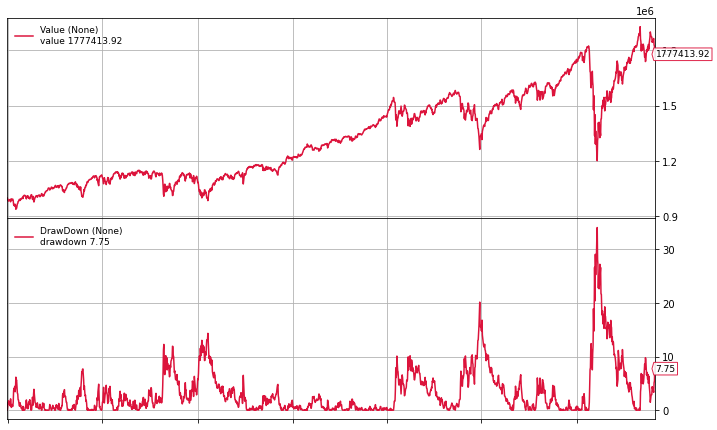

In [6]:
############################################################
# Run the backtest for the selected period
############################################################
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.plot() # We need to do this to avoid errors in inline plot

start = 1004
end = prices.shape[0] - 1

dd, cagr, sharpe = backtest([benchmark],
                            BuyAndHold,
                            start=start,
                            end=end,
                            plot=True)

In [7]:
############################################################
# Show Buy and Hold Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 34.10%
CAGR: 5.36%
Sharpe: 0.570


### 3.2 Rebalancing Quarterly using Riskfolio-Lib

In [8]:
############################################################
# Calculate assets returns
############################################################

pd.options.display.float_format = '{:.4%}'.format

data = prices.loc[:, ('Adj Close', slice(None))]
data.columns = assets
data = data.drop(columns=['SPY']).dropna()
returns = data.pct_change().dropna()
display(returns.head())

,AAPL,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.1729%,1.1807%,-0.6862%,-1.5607%,-1.3553%,-0.7576%,0.1771%,-0.3746%,-0.1198%,0.4194%,...,0.0323%,2.5949%,-0.2579%,1.8028%,0.8237%,-1.0445%,0.3708%,-1.8908%,0.1803%,3.5259%
2010-01-06,-1.5906%,1.5683%,0.3455%,-0.0396%,-0.7169%,-0.9715%,-1.1199%,-0.2686%,0.1865%,-0.9304%,...,-0.6137%,0.9452%,-1.1635%,1.3148%,-0.6066%,-1.9275%,1.9085%,3.4797%,-2.8754%,8.6956%
2010-01-07,-0.1849%,-1.5165%,1.6181%,0.0793%,2.1059%,0.9811%,-1.5201%,0.7181%,0.8244%,0.0384%,...,-1.0400%,-1.3451%,-1.2426%,1.3242%,-0.1369%,1.0295%,1.2283%,4.4490%,-0.5953%,11.2000%
2010-01-08,0.6648%,-0.5226%,0.2372%,-1.6640%,-0.2946%,-1.1797%,-0.6356%,2.7273%,1.3980%,0.7471%,...,0.6897%,0.6149%,-0.5298%,0.1307%,-1.8207%,0.4169%,-0.3978%,0.9411%,0.0630%,-1.6187%
2010-01-11,-0.8822%,0.3002%,-0.5746%,1.0475%,-0.6501%,0.7022%,0.3046%,4.0257%,1.1317%,-0.3043%,...,-1.2720%,0.4517%,1.2650%,1.6445%,0.6859%,-0.0461%,0.2197%,5.3484%,0.4095%,0.6094%


In [9]:
############################################################
# Selecting Dates for Rebalancing
############################################################

# Selecting last day of month of available data
index = returns.groupby([returns.index.year, returns.index.month]).tail(1).index
index_2 = returns.index

# Quarterly Dates
index = [x for x in index if float(x.month) % 3.0 == 0 ] 

# Dates where the strategy will be backtested
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 1000]

In [10]:
############################################################
# Building Constraints
############################################################

asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','NBL','APA','MMC',
                            'JPM','ZION','PSA','AAPL','BAX','BMY','LUV','PCAR',
                            'TXT','DHR','DE','MSFT','HPQ','SEE','VZ','CNP','NI'], 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Energy','Financials',
                              'Financials','Financials','Financials','Information Technology',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Industrials','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities'] }

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False],
               'Type': ['All Assets', 'All Classes', 'All Classes'],
               'Set': ['', 'Industry', 'Industry'],
               'Position': ['', '', ''],
               'Sign': ['<=', '<=', '>='],
               'Weight': [0.10, 0.20, 0.03],
               'Type Relative': ['', '', ''],
               'Relative Set': ['', '', ''],
               'Relative': ['', '', ''],
               'Factor': ['', '', '']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,10.0000%,,,,
1,False,All Classes,Industry,,<=,20.0000%,,,,
2,False,All Classes,Industry,,>=,3.0000%,,,,


In [11]:
############################################################
# Building constraint matrixes for Riskfolio Lib
############################################################

import riskfolio.ConstraintsFunctions as cf

A, B = cf.assets_constraints(constraints, asset_classes)

In [12]:
############################################################
# Building a loop that estimate optimal portfolios on
# rebalancing dates
############################################################

import riskfolio.Portfolio as pf

models = {}

# rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
#        'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

rms = ['MV', 'CVaR', 'WR', 'CDaR']

for j in rms:
    
    weights = pd.DataFrame([])

    for i in index_:
        Y = returns[i-1000:i] # taking last 4 years (250 trading days per year)

        # Building the portfolio object
        port = pf.Portfolio(returns=Y)
        
        # Add portfolio constraints
        port.ainequality = A
        port.binequality = B
        
        # Calculating optimum portfolio

        # Select method and estimate input parameters:

        method_mu='hist' # Method to estimate expected returns based on historical data.
        method_cov='hist' # Method to estimate covariance matrix based on historical data.

        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

        # Estimate optimal portfolio:

        model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
        rm = j # Risk measure used, this time will be variance
        obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
        hist = True # Use historical scenarios for risk measures that depend on scenarios
        rf = 0 # Risk free rate
        l = 0 # Risk aversion factor, only useful when obj is 'Utility'

        w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)
    
    models[j] = weights.copy()
    models[j].index = index_

In [13]:
############################################################
# Building the Asset Allocation Class
############################################################

class AssetAllocation(bt.Strategy):

    def __init__(self):

        j = 0
        for i in assets:
            setattr(self, i, self.datas[j])
            j += 1
        
        self.counter = 0
        
    def next(self):
        if self.counter in weights.index.tolist():
            for i in assets:
                w = weights.loc[self.counter, i]
                self.order_target_percent(getattr(self, i), target=w)
        self.counter += 1

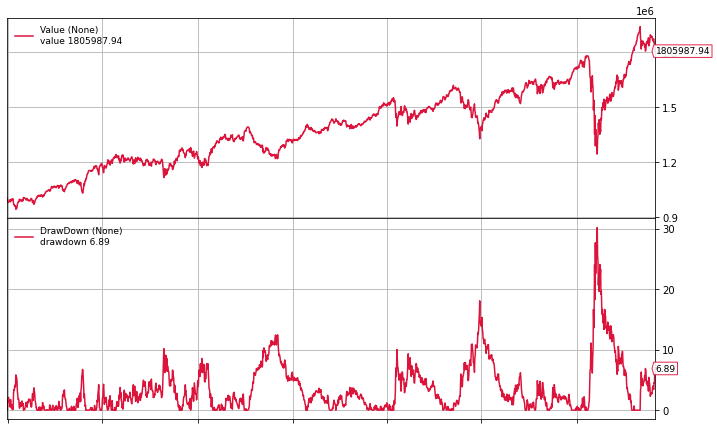

In [14]:
############################################################
# Backtesting Mean Variance Strategy
############################################################

assets = returns.columns.tolist()
weights = models['MV']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [15]:
############################################################
# Show Mean Variance Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 30.17%
CAGR: 5.51%
Sharpe: 0.660


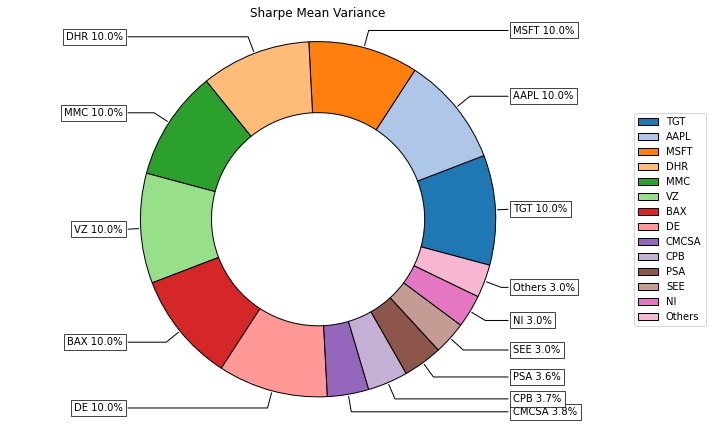

In [16]:
############################################################
# Plotting the composition of the last MV portfolio
############################################################

import riskfolio.PlotFunctions as plf

w = pd.DataFrame(models['MV'].iloc[-1,:])

ax = plf.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [17]:
############################################################
# Composition per Industry
############################################################

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes = w_classes.groupby(['Industry']).sum()
w_classes.columns = ['weights']
display(w_classes)

,weights
Industry,
Consumer Discretionary,13.7693%
Consumer Staples,3.6636%
Energy,3.0000%
Financials,13.5668%
Health Care,10.0004%
Industrials,19.9999%
Information Technology,19.9999%
Materials,3.0000%
Telecommunications Services,9.9999%


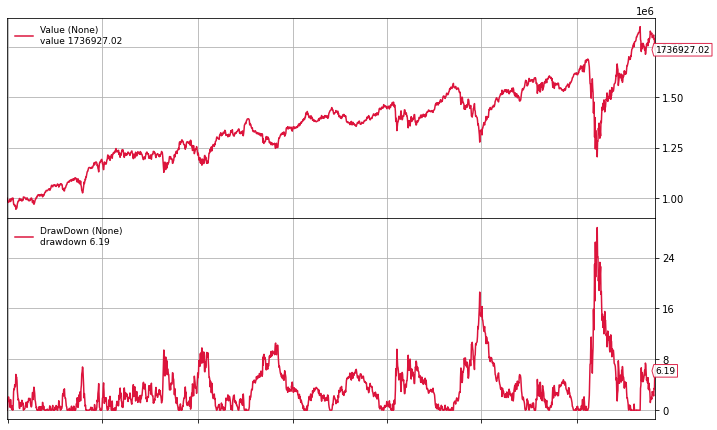

In [18]:
############################################################
# Backtesting Mean CVaR Strategy
############################################################

assets = returns.columns.tolist()
weights = models['CVaR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [19]:
############################################################
# Show CVaR Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 28.72%
CAGR: 5.13%
Sharpe: 0.671


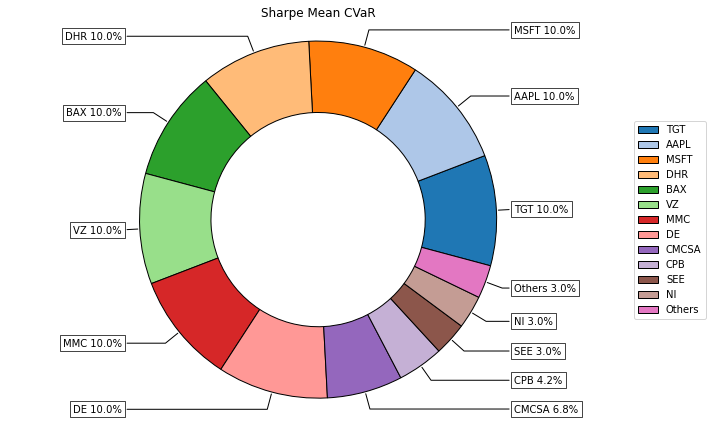

In [20]:
############################################################
# Plotting the composition of the last CVaR portfolio
############################################################

w = pd.DataFrame(models['CVaR'].iloc[-1,:])
ax = plf.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [21]:
############################################################
# Composition per Industry
############################################################

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes = w_classes.groupby(['Industry']).sum()
w_classes.columns = ['weights']
display(w_classes)

,weights
Industry,
Consumer Discretionary,16.8377%
Consumer Staples,4.1623%
Energy,3.0000%
Financials,10.0000%
Health Care,10.0000%
Industrials,20.0000%
Information Technology,20.0000%
Materials,3.0000%
Telecommunications Services,10.0000%


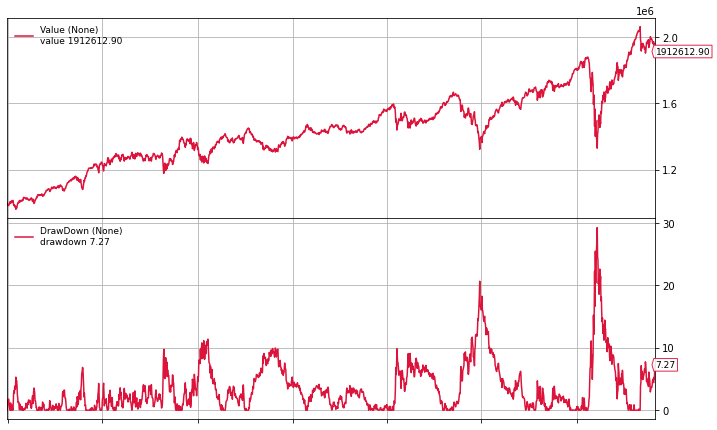

In [22]:
############################################################
# Backtesting Mean Worst Realization Strategy
############################################################

assets = returns.columns.tolist()
weights = models['WR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [23]:
############################################################
# Show Worst Realization Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 29.29%
CAGR: 6.07%
Sharpe: 0.598


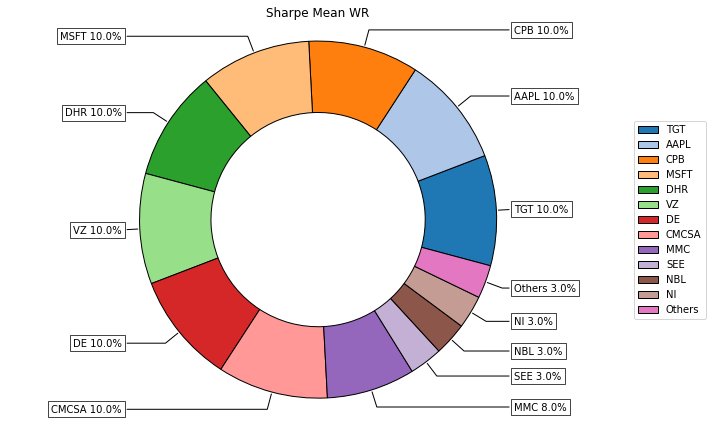

In [24]:
############################################################
# Plotting the composition of the last WR portfolio
############################################################

w = pd.DataFrame(models['WR'].iloc[-1,:])
ax = plf.plot_pie(w=w, title='Sharpe Mean WR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [25]:
############################################################
# Composition per Industry
############################################################

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes = w_classes.groupby(['Industry']).sum()
w_classes.columns = ['weights']
display(w_classes)

,weights
Industry,
Consumer Discretionary,20.0000%
Consumer Staples,10.0000%
Energy,3.0000%
Financials,8.0000%
Health Care,3.0000%
Industrials,20.0000%
Information Technology,20.0000%
Materials,3.0000%
Telecommunications Services,10.0000%


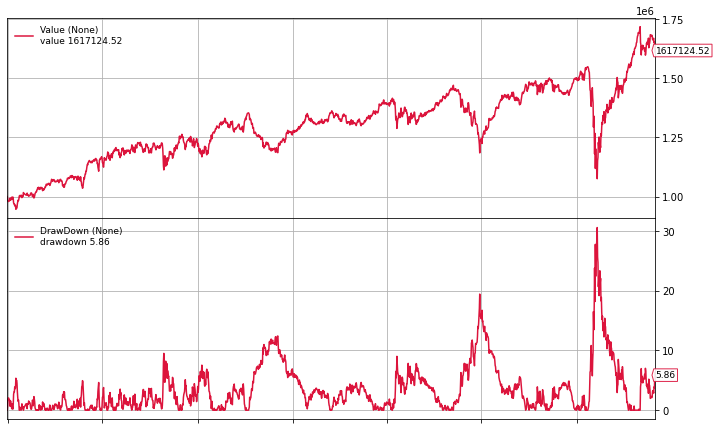

In [26]:
############################################################
# Backtesting Mean CDaR Strategy
############################################################

assets = returns.columns.tolist()
weights = models['CDaR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [27]:
############################################################
# Show CDaR Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 30.56%
CAGR: 4.42%
Sharpe: 0.578


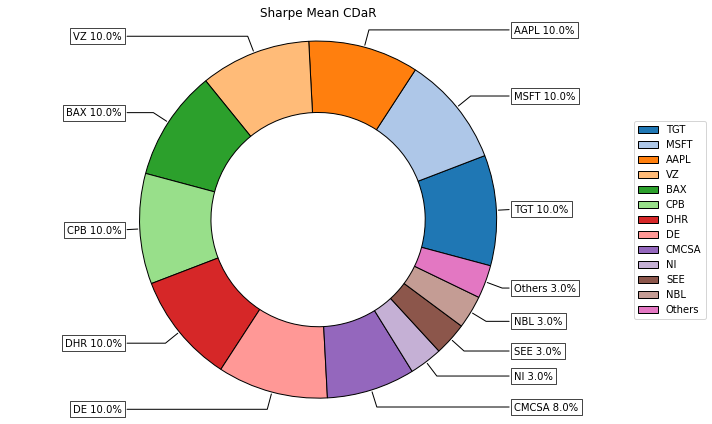

In [28]:
############################################################
# Plotting the composition of the last CDaR portfolio
############################################################

w = pd.DataFrame(models['CDaR'].iloc[-1,:])

ax = plf.plot_pie(w=w, title='Sharpe Mean CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [29]:
############################################################
# Composition per Industry
############################################################

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes = w_classes.groupby(['Industry']).sum()
w_classes.columns = ['weights']
display(w_classes)

,weights
Industry,
Consumer Discretionary,18.0000%
Consumer Staples,10.0000%
Energy,3.0000%
Financials,3.0000%
Health Care,10.0000%
Industrials,20.0000%
Information Technology,20.0000%
Materials,3.0000%
Telecommunications Services,10.0000%


## 4. Conclusion

In this example, the best strategy in terms of performance is __WR__ . The ranking of strategies in base of performance follows:

1. WR (6.07%): Worst Scenario or Minimax Model.
1. MV (5.51%): Mean Variance.
1. SPY (5.36%): Buy and Hold SPY.
1. CVaR (5.13%): Conditional Value at Risk.
1. CDaR (4.42%): Conditional Drawdown at Risk.

On the other hand, the best strategy in terms of Sharpe Ratio is __CVaR__ . The ranking of strategies in base of Sharpe Ratio follows:

1. CVaR (0.671): Conditional Value at Risk.
1. MV (0.660): Mean Variance.
1. WR (0.598): Worst Scenario or Minimax Model.
1. CDaR (0.578): Conditional Drawdown at Risk.
1. SPY (0.570): Buy and Hold SPY.